In [1]:
import sys

sys.path.append('../utils')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from typing import Union, List
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial

In [8]:
## UTILS
def filter_synapse_table(synapse_table: pd.DataFrame,
                         pre_root_ids=None,
                         post_root_ids=None):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(
            pre_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(
            post_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


def calculate_neuronal_distance(
        pre_cell_df: pd.DataFrame,
        post_cell_df: pd.DataFrame,
        distance_type: Union[str, List[str]] = "3d") -> pd.DataFrame:
    """
    Calculate pairwise distances between pre- and post-synaptic cells.
    
    Parameters
    ----------
    pre_cell_df : pd.DataFrame
        DataFrame containing presynaptic cell information with position columns
    post_cell_df : pd.DataFrame
        DataFrame containing postsynaptic cell information with position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns for cell ID pairs and calculated distances
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Calculate distances for each type
    distances = {}
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        pre_positions = pre_cell_df[dist_columns].values
        post_positions = post_cell_df[dist_columns].values

        pairwise_distances = spatial.distance.cdist(pre_positions,
                                                    post_positions)
        distances[dist_type] = pairwise_distances.flatten()

    id_pairs = list(
        itertools.product(pre_cell_df["pt_root_id"],
                          post_cell_df["pt_root_id"]))
    result_df = pd.DataFrame(id_pairs,
                             columns=['pre_pt_root_id', 'post_pt_root_id'])

    # Add distance columns
    for dist_type, dist_values in distances.items():
        result_df[f'distance_{dist_type}'] = dist_values

    # Remove self-connections (where pre and post IDs are the same)
    result_df = result_df[result_df['pre_pt_root_id'] !=
                          result_df['post_pt_root_id']]

    return result_df


def add_distance_columns(df: pd.DataFrame, distance_type: str | list[str]):
    """
    Add distance columns to a DataFrame containing cell pairs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell pairs with pre_ and post_ position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added distance columns
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Make a copy to avoid modifying the original DataFrame
    result_df = df.copy()

    # Calculate distances for each type
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        # Get pre and post position columns
        pre_columns = [f"pre_{col}" for col in dist_columns]
        post_columns = [f"post_{col}" for col in dist_columns]

        # Calculate distance row by row
        pre_positions = result_df[pre_columns].values
        post_positions = result_df[post_columns].values

        # Calculate Euclidean distance for each row
        distances = np.sqrt(np.sum((pre_positions - post_positions)**2, axis=1))

        # Add distance column
        result_df[f'distance_{dist_type}'] = distances

    return result_df


def create_pairs_df(df_pre, df_post):

    # Do a cartesian product (self-merge on nothing)
    df_pre = df_pre.add_prefix("pre_")
    df_post = df_post.add_prefix("post_")
    df_pairs = df_pre.merge(df_post, how="cross")

    # Remove self-pairs
    df_pairs = df_pairs[df_pairs["pre_id"] != df_pairs["post_id"]].reset_index(
        drop=True)

    return df_pairs

In [9]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [10]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy"))
axon_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids,
                                             dendrite_proof_root_ids)]

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {len(proof_root_ids)}"
)


There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [11]:
cell_df = pd.read_feather(
    f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [12]:
# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[
    np.isin(cell_df['pt_root_id'], axon_proof_root_ids) &
    np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)].reset_index(
        drop=True)

cell_axon_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                         axon_proof_root_ids)]

cell_dendrite_proofread_df = cell_df[np.isin(cell_df['pt_root_id'],
                                             dendrite_proof_root_ids)]
# cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] ==
#                                          "L3-IT"]

In [27]:
#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.
# only use synapses with proofread cells

syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

# every synapse with axon proofread cells
axon_proofread_syn_df = filter_synapse_table(
    syn_df,
    pre_root_ids=axon_proof_root_ids,
    post_root_ids=None,
).reset_index(drop=True)

dendrite_proofread_syn_df = filter_synapse_table(
    syn_df,
    pre_root_ids=None,
    post_root_ids=dendrite_proof_root_ids,
).reset_index(drop=True)

print(syn_df.shape, axon_proofread_syn_df.shape,
      dendrite_proofread_syn_df.shape)

(8204497, 13) (2849433, 13) (6745837, 13)


In [14]:
coregistered_info = pd.read_feather(f"{data_dir}/coregistration_1196.feather")

## Simulate having random cells defined as choroist and soloist cells

In [15]:
# Randomly assign 50% as choroist and 50% as soloist
np.random.seed(42)  # for reproducibility
n_cells = len(coregistered_info)
n_choroist = n_cells // 2
n_soloist = n_cells - n_choroist

# Create random assignment
random_indices = np.random.permutation(n_cells)
choroist_indices = random_indices[:n_choroist]
soloist_indices = random_indices[n_choroist:]

# Add assignment column
coregistered_info = coregistered_info.copy()
coregistered_info['cell_role'] = 'soloist'
coregistered_info.loc[choroist_indices, 'cell_role'] = 'choroist'

print(
    f"Assigned {n_choroist} cells as choroist and {n_soloist} cells as soloist")
print(coregistered_info['cell_role'].value_counts())

coregistered_info

# Add p_coupling column with uniform random values between -2 and 2
np.random.seed(42)  # for reproducibility
coregistered_info['p_coupling'] = np.random.uniform(-2,
                                                    2,
                                                    size=len(coregistered_info))


Assigned 285 cells as choroist and 286 cells as soloist
cell_role
soloist     286
choroist    285
Name: count, dtype: int64


In [16]:
coregisterd_with_coupling = cell_df.merge(coregistered_info,
                                          on='pt_root_id',
                                          how='right')

In [17]:
cell_df

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
0,228132,632.828,749.849,738.270,-323.721448,549.910283,392.909833,864691132737039043,458.464831,None,None
1,543247,1304.922,977.915,83.880,330.339020,595.962276,-306.424551,864691132730839988,73.345940,None,None
2,203262,624.680,531.094,283.770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT
3,350562,894.573,478.559,163.530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT
4,718122,1729.859,674.111,781.200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None
...,...,...,...,...,...,...,...,...,...,...,...
207450,527607,1262.940,628.094,734.445,352.037267,418.290963,436.647625,864691132639606383,100.547645,None,None
207451,168582,491.518,1057.067,92.070,-521.847320,688.587871,-335.347345,864691133042980384,369.919126,None,None
207452,29422,302.330,415.005,81.855,-570.524838,35.550649,-177.610742,0,285.031368,None,None
207453,422767,1065.603,538.932,36.405,191.665102,141.490682,-231.412518,864691132851361283,394.724290,None,None


In [28]:
# Count the number of inputs to each cell (post-synaptic)
inputs_per_cell = dendrite_proofread_syn_df.groupby('post_pt_root_id').size()
print("Number of inputs per cell:")
print(inputs_per_cell.head())
print(f"\nTotal cells receiving inputs: {len(inputs_per_cell)}")
print(f"Average inputs per cell: {inputs_per_cell.mean():.2f}")

Number of inputs per cell:
post_pt_root_id
864691132533275738     21
864691132533347418    112
864691132533489754      1
864691132533521754      9
864691132533614170     10
dtype: int64

Total cells receiving inputs: 41154
Average inputs per cell: 163.92


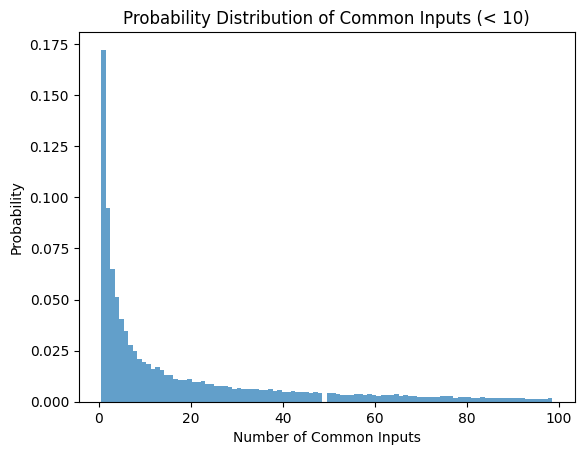

In [34]:
# Create probability distribution
values = inputs_per_cell.values[inputs_per_cell.values < 100]
counts, bins = np.histogram(values, bins=100)
probabilities = counts / counts.sum()

plt.bar(bins[:-1], probabilities, width=np.diff(bins), alpha=0.7)
plt.xlabel('Number of Common Inputs')
plt.ylabel('Probability')
plt.title('Probability Distribution of Common Inputs (< 10)')
#plt.ylim(0., 1.)
#plt.yscale('log')
plt.show()

In [35]:
dendrite_proofread_syn_coregistered_df = dendrite_proofread_syn_df.merge(
    coregistered_info,
    left_on='post_pt_root_id',
    right_on='pt_root_id',
    how='right')

inputs_per_cell_coregistered = dendrite_proofread_syn_coregistered_df.groupby(
    'post_pt_root_id').size()
print("Number of inputs per cell:")
print(inputs_per_cell_coregistered.head())
print(f"\nTotal cells receiving inputs: {len(inputs_per_cell_coregistered)}")
print(f"Average inputs per cell: {inputs_per_cell_coregistered.mean():.2f}")

Number of inputs per cell:
post_pt_root_id
8.646911e+17     900
8.646911e+17    1091
8.646911e+17      84
8.646911e+17      18
8.646911e+17    2887
dtype: int64

Total cells receiving inputs: 517
Average inputs per cell: 1688.57


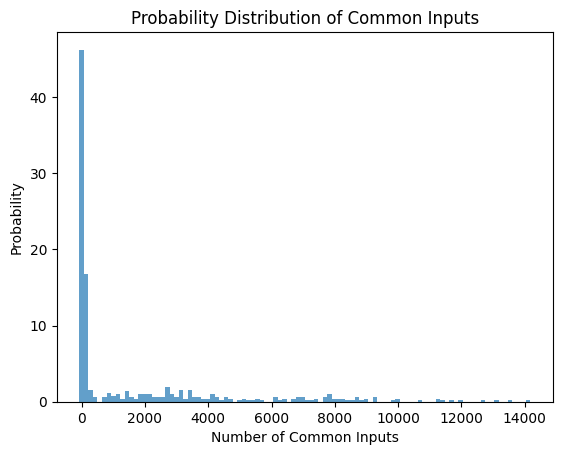

In [ ]:
# Create probability distribution
values = inputs_per_cell_coregistered.values
counts, bins = np.histogram(values, bins=100)
probabilities = counts / counts.sum() * 100

plt.bar(bins[:-1], probabilities, width=np.diff(bins), alpha=0.7)
plt.xlabel('Number of Common Inputs')
plt.ylabel('Probability')
plt.title('Probability Distribution of Common Inputs')
#plt.ylim(0., 1.)
#plt.yscale('log')
plt.show()

In [ ]:
inputs_per_cell_coregistered.shape

post_pt_root_id
8.646911e+17     900
8.646911e+17    1091
8.646911e+17      84
8.646911e+17      18
8.646911e+17    2887
                ... 
8.646911e+17      48
8.646911e+17      36
8.646911e+17     332
8.646911e+17      59
8.646911e+17      41
Length: 517, dtype: int64

In [41]:
pd.DataFrame(inputs_per_cell_coregistered)

,0
post_pt_root_id,
8.646911e+17,900
8.646911e+17,1091
8.646911e+17,84
8.646911e+17,18
8.646911e+17,2887
...,...
8.646911e+17,48
8.646911e+17,36
8.646911e+17,332


In [42]:
inputs_per_cell_coregistered = dendrite_proofread_syn_coregistered_df.groupby(
    'post_pt_root_id').size().reset_index(name='inputs_per_cell')

In [43]:
inputs_per_cell_coregistered

,post_pt_root_id,inputs_per_cell
0,8.646911e+17,900
1,8.646911e+17,1091
2,8.646911e+17,84
3,8.646911e+17,18
4,8.646911e+17,2887
...,...,...
512,8.646911e+17,48
513,8.646911e+17,36
514,8.646911e+17,332
515,8.646911e+17,59


In [46]:
coregisterd_with_coupling

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume_x,cell_type_coarse,cell_type,column,volume_y,plane,roi,cell_role,p_coupling
0,279077,884.485,551.581,326.745,5.289889,234.119346,61.771196,864691132830842994,368.973950,E,L3-IT,1,3,0,143,choroist,-0.501840
1,276433,740.071,612.419,204.750,-142.011852,261.053111,-70.219681,864691132741466457,321.666672,E,L3-IT,1,3,2,40,soloist,1.802857
2,352939,927.553,616.377,287.280,42.142603,286.280855,9.472949,864691132770893729,275.509430,E,L3-IT,1,3,3,98,choroist,0.927976
3,352939,927.553,616.377,287.280,42.142603,286.280855,9.472949,864691132770893729,275.509430,E,L3-IT,1,3,3,98,choroist,0.394634
4,354027,897.832,551.658,344.025,18.165122,238.797609,78.834508,864691132999240117,245.712828,E,L3-IT,1,3,0,100,soloist,-1.375925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,353337,916.922,592.398,308.745,33.793975,268.797310,35.852350,864691132744008540,320.096619,E,L3-IT,1,3,2,236,choroist,-0.431024
567,366608,964.956,650.366,168.615,79.521924,287.086386,-113.906192,864691132810202401,324.457758,E,L3-IT,1,3,2,383,choroist,-0.250100
568,290884,848.944,658.203,114.615,-35.600955,280.693957,-168.343163,864691132925592361,281.775553,E,L4-IT,1,3,2,393,soloist,1.616635
569,277458,799.668,584.561,247.725,-80.593107,245.269306,-22.295072,864691132884727983,324.333108,E,L3-IT,1,3,0,89,choroist,-0.606978


In [49]:
coregisterd_with_coupling_and_inputs_per_cell = coregisterd_with_coupling.merge(
    inputs_per_cell_coregistered,
    left_on='pt_root_id',
    right_on='post_pt_root_id',
    how='left')

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Prepare data for logistic regression
X = coregisterd_with_coupling_and_inputs_per_cell[
    'inputs_per_cell'].values.reshape(-1, 1)
y = (coregisterd_with_coupling_and_inputs_per_cell['p_coupling']
     > 0).astype(int)  # Convert to binary

# Remove any NaN values
mask = ~(np.isnan(X.flatten()) | np.isnan(y))
X = X[mask]
y = y[mask]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)

print(f"Coefficient: {log_reg.coef_[0][0]:.4f}")
print(f"Intercept: {log_reg.intercept_[0]:.4f}")
print(f"Score: {log_reg.score(X_scaled, y):.4f}")

Coefficient: -0.1311
Intercept: 0.1090
Score: 0.5403


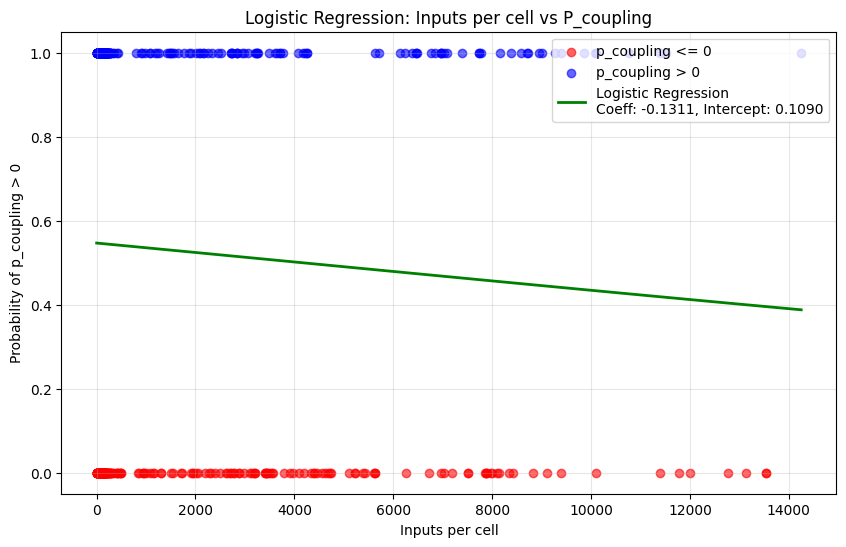

Number of valid data points: 533


In [ ]:
import matplotlib.pyplot as plt

# Create a range of x values for plotting the logistic curve
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_scaled = scaler.transform(x_range)

# Predict probabilities for the range
y_prob = log_reg.predict_proba(x_range_scaled)[:, 1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X[y == 0],
            y[y == 0],
            alpha=0.6,
            label='p_coupling <= 0',
            color='red')
plt.scatter(X[y == 1],
            y[y == 1],
            alpha=0.6,
            label='p_coupling > 0',
            color='blue')

# Plot the logistic regression curve
plt.plot(
    x_range,
    y_prob,
    'g-',
    linewidth=2,
    label=
    f'Logistic Regression\nCoeff: {log_reg.coef_[0][0]:.4f}, Intercept: {log_reg.intercept_[0]:.4f}'
)

plt.xlabel('Inputs per cell')
plt.ylabel('Probability of p_coupling > 0')
plt.title('Logistic Regression: Inputs per cell vs P_coupling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of valid data points: {mask.sum()}")